In [13]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon

In [14]:
# Define a general dataframe to hold all data
all_data = pd.DataFrame()

for i in range(1, 11):
    # Create a directory for each run
    data_file_path = f'run{i}/data.csv'

    # Read the CSV file into a pandas dataframe
    df = pd.read_csv(data_file_path)

    # Add a new column 'run' with the value of i
    df['run'] = i

    # Append the dataframe to the all_data dataframe
    all_data = pd.concat([all_data, df], ignore_index=True)

print (all_data.head())

         asm  n_macro  n_conditional  n_update   approach  exec_time  \
0  Ascensore        1              6         7  evoavalla      78856   
1  Ascensore        1              6         7     random         29   
2  Ascensore        1              6         7       atgt        816   
3     ATM3v2       10             21        17  evoavalla      84221   
4     ATM3v2       10             21        17     random         95   

   n_scenarios  n_step  n_set  n_check  macro_coverage  branch_coverage  \
0            2       6      3       16             1.0         0.833333   
1            2       6      4       11             1.0         0.583333   
2            7      11     11       17             1.0         0.833333   
3            0       0      0        0             0.0         0.000000   
4            5      25     24       79             0.6         0.285714   

   update_rule_coverage  n_failing_scenarios  run  
0              1.000000                    0    1  
1           

In [15]:
# We need to fill the dataframe. Fir each asm and each run, we need values with approach = evoavalla, approach = random, and approach = atgt. If they are not present, we need to fill them with NaN
asms = all_data['asm'].unique()
approaches = all_data['approach'].unique()

for asm in asms:
    for run in range(1, 11):
        for approach in approaches:
            # Check if the combination exists
            if not ((all_data['asm'] == asm) & (all_data['run'] == run) & (all_data['approach'] == approach)).any():
                # If it doesn't exist, create a new row with NaN values
                new_row = {
                    'asm': asm,
                    'run': run,
                    'approach': approach,
                    'n_failing_scenarios': float('nan'),
                    'update_rule_coverage': float('nan'),
                    'branch_coverage': float('nan'),
                    'macro_coverage': float('nan'),
                    'n_checks': float('nan'),
                    'n_sets': float('nan'),
                    'n_step': float('nan'),
                    'n_scenarios': 0
                }
                all_data = all_data.append(new_row, ignore_index=True)

/var/folders/g5/l18bns3n361cb795218jlv4c0000gn/T/ipykernel_71050/2672976000.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = all_data.append(new_row, ignore_index=True)
/var/folders/g5/l18bns3n361cb795218jlv4c0000gn/T/ipykernel_71050/2672976000.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = all_data.append(new_row, ignore_index=True)
/var/folders/g5/l18bns3n361cb795218jlv4c0000gn/T/ipykernel_71050/2672976000.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = all_data.append(new_row, ignore_index=True)
/var/folders/g5/l18bns3n361cb795218jlv4c0000gn/T/ipykernel_71050/2672976000.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

In [16]:
# Rename approach atgt to ATGT
all_data['approach'] = all_data['approach'].replace('atgt', 'ATGT')
# Rename approach evoavalla to EvoAValla
all_data['approach'] = all_data['approach'].replace('evoavalla', 'EvoAvalla')
# Rename approach random to Random
all_data['approach'] = all_data['approach'].replace('random', 'Random')
# Remove all lines where 'asm' is Ferryman
all_data = all_data[all_data['asm'] != 'Ferryman']
# Print the number of distinct asms
print("Number of distinct asms: ", all_data['asm'].nunique())

Number of distinct asms:  21


Approach: EvoAvalla, Mean Execution Time: 80401.29, Std Dev: 11759.14
Approach: Random, Mean Execution Time: 110.41, Std Dev: 222.79
Approach: ATGT, Mean Execution Time: 1105.33, Std Dev: 947.81


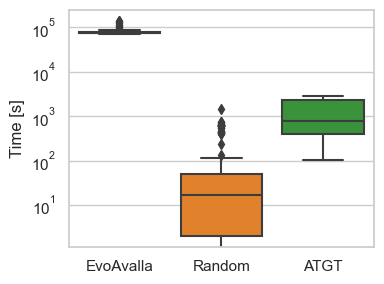

In [17]:
# For each approach, calculate the mean and standard deviation of the 'exec_time' column    
for approach in all_data['approach'].unique():
    # Filter the dataframe for the current approach
    approach_data = all_data[all_data['approach'] == approach]

    # Calculate mean and standard deviation
    mean_exec_time = approach_data['exec_time'].mean()
    std_exec_time = approach_data['exec_time'].std()

    # Print the results
    print(f"Approach: {approach}, Mean Execution Time: {mean_exec_time:.2f}, Std Dev: {std_exec_time:.2f}")

# Generate a boxplot for the execution times of each approach
# Set the style of seaborn
sns.set(style="whitegrid")
# Create a boxplot
plt.figure(figsize=(4, 3))
# EvoAvalla must be blue, Random must be orange, and ATGT must be green
sns.set_palette(['#1f77b4', '#ff7f0e', '#2ca02c'])
sns.boxplot(x='approach', y='exec_time', data=all_data)
# set log scale for y-axis
plt.yscale('log')
plt.xlabel('')
plt.ylabel('Time [s]')
plt.tight_layout()

# Save the image as pdf
plt.savefig('images/boxplot_exec_time.pdf', bbox_inches='tight')

In [18]:
# For each approach, calculate the mean and standard deviation of the 'branch_coverage' column
for approach in all_data['approach'].unique():
    # Filter the dataframe for the current approach
    approach_data = all_data[all_data['approach'] == approach]

    # Calculate mean and standard deviation
    mean_branch_coverage = approach_data['branch_coverage'].mean()
    std_branch_coverage = approach_data['branch_coverage'].std()

    # Print the results
    print(f"Approach: {approach}, Mean Branch Coverage: {mean_branch_coverage:.2f}, Std Dev: {std_branch_coverage:.2f}")

Approach: EvoAvalla, Mean Branch Coverage: 0.57, Std Dev: 0.32
Approach: Random, Mean Branch Coverage: 0.47, Std Dev: 0.28
Approach: ATGT, Mean Branch Coverage: 0.84, Std Dev: 0.33


In [19]:
# For each approach, calculate the mean and standard deviation of the 'macro_coverage' column
for approach in all_data['approach'].unique():
    # Filter the dataframe for the current approach
    approach_data = all_data[all_data['approach'] == approach]

    # Calculate mean and standard deviation
    mean_macro_coverage = approach_data['macro_coverage'].mean()
    std_macro_coverage = approach_data['macro_coverage'].std()

    # Print the results
    print(f"Approach: {approach}, Mean Macro Coverage: {mean_macro_coverage:.2f}, Std Dev: {std_macro_coverage:.2f}")

Approach: EvoAvalla, Mean Macro Coverage: 0.79, Std Dev: 0.33
Approach: Random, Mean Macro Coverage: 0.63, Std Dev: 0.39
Approach: ATGT, Mean Macro Coverage: 0.88, Std Dev: 0.33


In [20]:
# For each approach, calculate the mean and standard deviation of the 'update_rule_coverage' column
for approach in all_data['approach'].unique():
    # Filter the dataframe for the current approach
    approach_data = all_data[all_data['approach'] == approach]

    # Calculate mean and standard deviation
    mean_update_rule_coverage = approach_data['update_rule_coverage'].mean()
    std_update_rule_coverage = approach_data['update_rule_coverage'].std()

    # Print the results
    print(f"Approach: {approach}, Mean Update Rule Coverage: {mean_update_rule_coverage:.2f}, Std Dev: {std_update_rule_coverage:.2f}")

Approach: EvoAvalla, Mean Update Rule Coverage: 0.58, Std Dev: 0.38
Approach: Random, Mean Update Rule Coverage: 0.36, Std Dev: 0.31
Approach: ATGT, Mean Update Rule Coverage: 0.86, Std Dev: 0.33


In [21]:
# For each approach, calculate the mean and standard deviation of the 'n_scenarios' column
for approach in all_data['approach'].unique():
    # Filter the dataframe for the current approach
    approach_data = all_data[all_data['approach'] == approach]

    # Calculate mean and standard deviation
    mean_n_scenarios = approach_data['n_scenarios'].mean()
    std_n_scenarios = approach_data['n_scenarios'].std()

    # Print the results
    print(f"Approach: {approach}, Mean Number of Scenarios: {mean_n_scenarios:.2f}, Std Dev: {std_n_scenarios:.2f}")

Approach: EvoAvalla, Mean Number of Scenarios: 2.60, Std Dev: 5.05
Approach: Random, Mean Number of Scenarios: 4.34, Std Dev: 4.70
Approach: ATGT, Mean Number of Scenarios: 4.33, Std Dev: 8.48


In [22]:
# For each approach, calculate the mean and standard deviation of the 'n_step' column
for approach in all_data['approach'].unique():
    # Filter the dataframe for the current approach
    approach_data = all_data[all_data['approach'] == approach]

    # Calculate mean and standard deviation
    mean_n_step = approach_data['n_step'].mean()
    std_n_step = approach_data['n_step'].std()

    # Print the results
    print(f"Approach: {approach}, Mean Number of Steps: {mean_n_step:.2f}, Std Dev: {std_n_step:.2f}")

Approach: EvoAvalla, Mean Number of Steps: 9.40, Std Dev: 14.23
Approach: Random, Mean Number of Steps: 16.14, Std Dev: 13.84
Approach: ATGT, Mean Number of Steps: 168.75, Std Dev: 318.66


Approach: EvoAvalla, Number of unique asms with n_scenarios = 0 or NaN: 9 - ['ATM3v2' 'Tcas' 'GuessBigNumber' 'Integer_train' 'QuickSort' 'SmartHome'
 'SwapSortOnSeq' 'LIFT' 'Population']
Approach: Random, Number of unique asms with n_scenarios = 0 or NaN: 1 - ['Integer_train']
Approach: ATGT, Number of unique asms with n_scenarios = 0 or NaN: 13 - ['ATM3v2' 'CashPoint' 'Dado' 'GuessBigNumber' 'Integer_train' 'QuickSort'
 'RegistroDiCassav4' 'SiGistica' 'SmartHome' 'Stufa' 'SwapSortOnSeq'
 'LIFT' 'Population']


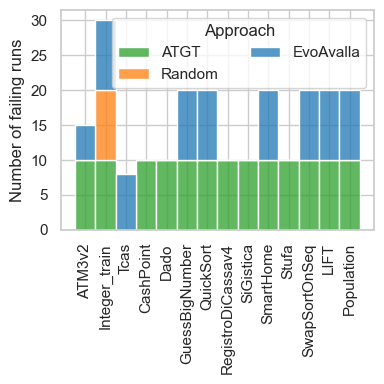

In [23]:
# For each approach, calculate the number of distinc asm for which at least one run produced n_scenarios = 0 or n_scenarios = NaN
for approach in all_data['approach'].unique():
    # Filter the dataframe for the current approach
    approach_data = all_data[all_data['approach'] == approach]

    # Get the unique asms for which at least one run produced n_scenarios = 0 or n_scenarios = NaN
    unique_asms = approach_data[(approach_data['n_scenarios'] == 0) | (approach_data['n_scenarios'].isna())]['asm'].unique()

    # Print the results
    print(f"Approach: {approach}, Number of unique asms with n_scenarios = 0 or NaN: {len(unique_asms)} - {unique_asms}")

# Create an histogram showing the number of asms for each technique for which at least one run produced n_scenarios = 0 or n_scenarios = NaN
plt.figure(figsize=(4, 4))
sns.histplot(data=all_data[(all_data['n_scenarios'] == 0) | (all_data['n_scenarios'].isna())], x='asm', hue='approach', multiple='stack')
plt.ylabel('Number of failing runs')
plt.xticks(rotation=90)
plt.xlabel('')
plt.tight_layout()
# Set the legend 
plt.legend(title='Approach', loc='upper right', labels=['ATGT', 'Random', 'EvoAvalla'], ncols=2)

# Save the image as pdf
plt.savefig('images/histogram_asm_zero_scenarios.pdf', bbox_inches='tight')

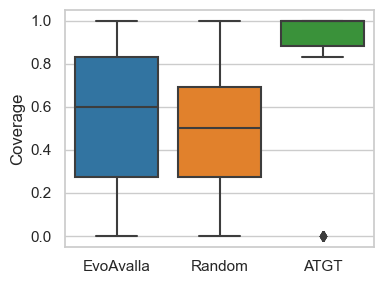

In [ ]:
# Generate a box-plot with the update rule, macro and branch coverage for all three approaches
sns.set(style="whitegrid")
# Create a boxplot
plt.figure(figsize=(4, 3))
# EvoAvalla must be blue, Random must be orange, and ATGT must be green
sns.set_palette(['#1f77b4', '#ff7f0e', '#2ca02c'])
sns.boxplot(x='approach', y='branch_coverage', data=all_data)
# set log scale for y-axis
plt.xlabel('')
plt.ylabel('Branch Coverage')
plt.tight_layout()

# Save the image as pdf
plt.savefig('images/boxplot_branch_coverage.pdf', bbox_inches='tight')

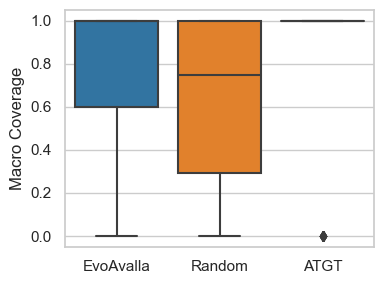

In [30]:
sns.set(style="whitegrid")
# Create a boxplot
plt.figure(figsize=(4, 3))
# EvoAvalla must be blue, Random must be orange, and ATGT must be green
sns.set_palette(['#1f77b4', '#ff7f0e', '#2ca02c'])
sns.boxplot(x='approach', y='macro_coverage', data=all_data)
# set log scale for y-axis
plt.xlabel('')
plt.ylabel('Macro Coverage')
plt.tight_layout()

# Save the image as pdf
plt.savefig('images/boxplot_macro_coverage.pdf', bbox_inches='tight')

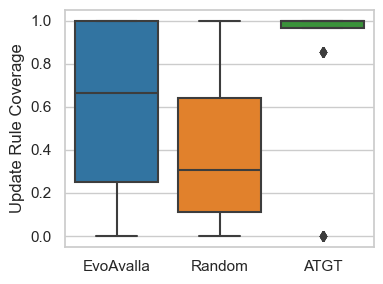

In [31]:
sns.set(style="whitegrid")
# Create a boxplot
plt.figure(figsize=(4, 3))
# EvoAvalla must be blue, Random must be orange, and ATGT must be green
sns.set_palette(['#1f77b4', '#ff7f0e', '#2ca02c'])
sns.boxplot(x='approach', y='update_rule_coverage', data=all_data)
# set log scale for y-axis
plt.xlabel('')
plt.ylabel('Update Rule Coverage')
plt.tight_layout()

# Save the image as pdf
plt.savefig('images/boxplot_updaterule_coverage.pdf', bbox_inches='tight')